<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Loading-data-and-preparing-structres" data-toc-modified-id="Loading-data-and-preparing-structres-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading data and preparing structres</a></span><ul class="toc-item"><li><span><a href="#Preprocessing-functions" data-toc-modified-id="Preprocessing-functions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Preprocessing functions</a></span></li><li><span><a href="#Loading-and-visualizing-data" data-toc-modified-id="Loading-and-visualizing-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Loading and visualizing data</a></span></li><li><span><a href="#Wavelet-for-feature-extraction" data-toc-modified-id="Wavelet-for-feature-extraction-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Wavelet for feature extraction</a></span></li><li><span><a href="#Custom-split" data-toc-modified-id="Custom-split-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Custom split</a></span></li></ul></li><li><span><a href="#Feature-selection-using-picked-channels+PCA" data-toc-modified-id="Feature-selection-using-picked-channels+PCA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature selection using picked channels+PCA</a></span><ul class="toc-item"><li><span><a href="#SVC" data-toc-modified-id="SVC-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>SVC</a></span></li><li><span><a href="#MLP" data-toc-modified-id="MLP-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>MLP</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#KNN" data-toc-modified-id="KNN-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>KNN</a></span></li><li><span><a href="#Box-plot-comparison" data-toc-modified-id="Box-plot-comparison-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Box plot comparison</a></span></li></ul></li><li><span><a href="#Feature-extraction-using-FDR+PCA" data-toc-modified-id="Feature-extraction-using-FDR+PCA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature extraction using FDR+PCA</a></span><ul class="toc-item"><li><span><a href="#SVC" data-toc-modified-id="SVC-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>SVC</a></span></li><li><span><a href="#MLP" data-toc-modified-id="MLP-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>MLP</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#KNN" data-toc-modified-id="KNN-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>KNN</a></span></li><li><span><a href="#Box-plot-comparison" data-toc-modified-id="Box-plot-comparison-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Box plot comparison</a></span></li></ul></li><li><span><a href="#Validation" data-toc-modified-id="Validation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Validation</a></span><ul class="toc-item"><li><span><a href="#Original-dataset" data-toc-modified-id="Original-dataset-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Original dataset</a></span></li></ul></li><li><span><a href="#Summary-and-comment" data-toc-modified-id="Summary-and-comment-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Summary and comment</a></span></li></ul></div>

# Imports

In [1]:
import numpy as np
import scipy as sc
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import os
import datetime
import random

import pandas as pd
import mne
import pywt

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

# Loading data and preparing structres
The data used was from private database from 72 subjects containg 40minutes EEG recording during eyes-closed and eyes-opend resting state. The subjects were also classified in terms of mental condition on control group, depression group and rem group.

## Preprocessing functions

In [2]:
def load_signals(path):
    '''
    Loading EEG signals from directory in EDF format. Using mne.io.read_raw_edf
        
    Args:
    -----
            path (str): path to directory containing EDF signals

    Returns:
    --------
            dict (dict): Raw objects of EEG
    '''
        
    dict = {}
    for i, file in enumerate(os.listdir(path)):
        dict[i] = mne.io.read_raw_edf(path+file, preload=True)
    return dict

In [3]:
def prepare_timedata(df):
    '''
    Converting time stamps in format HH:MM:SS.f to seconds for furhter analysis.
        
    Args:
    -----
            df (pandas.DataFrame): containg descripiton of EEG signals (eeg_opis.xlsx file)

    Returns:
    --------
            df (pandas.DataFrame): df with converted time stamps to seconds
    '''
    for i, val in enumerate(df['RecordStart']):
        timedelta = datetime.datetime.strptime(val, " %H:%M:%S.%f") - datetime.datetime(1900, 1, 1)
        
        for j in df.columns[4:]:
            df[j][i] = (datetime.datetime.strptime(df[j][i], " %H:%M:%S.%f") - datetime.datetime(1900, 1, 1)).total_seconds() - timedelta.total_seconds()
    
    #sort alphabetically by name of file to match order in signals from directory
    df.sort_values('EEG_File', ignore_index=True, inplace=True)
        
    return df

In [4]:
def fix_info(raw, drop_ch):
    '''
    Fixing info attribute of Raw object after changes: 
        - dropping unnecessary channels
        - renaming channels
        - resampling if not 200Hz
        - setting standard montage of channels
        - setting standard montage of channelsng average refrence across channels
        
    Args:
    -----
            raw (mne.Raw): raw instance of eeg 
            drop_ch (list): names of channels to drop from raw object

    Returns:
    --------
            eeg (mne.Raw): changed copy of raw instance of eeg 
    '''
    eeg = raw.copy()
    ch_names = []
    
    eeg.drop_channels(drop_ch)
    s, t = eeg[:]
    
    for i, ch in enumerate(eeg.info['ch_names']):
        new_ch = ch.split('-')[0]
    
        if new_ch == 'FZ': new_ch = 'Fz'
        if new_ch == 'PZ': new_ch = 'Pz'
        if new_ch == 'CZ': new_ch = 'Cz'
    
        ch_names.append(new_ch)

    if raw.info['sfreq'] != 200:
        eeg = eeg.resample(200)
        
    montage = mne.channels.make_standard_montage('standard_1020')
    info = mne.create_info(ch_names=ch_names, sfreq=eeg.info['sfreq'], ch_types='eeg')
    info.set_montage(montage)

    eeg.info = info
    mne.set_eeg_reference(eeg, ref_channels='average', copy=False)

    return eeg

In [5]:
def apply_fix_notch(data, drop_ch):
    '''
    Iterate through signals in dict, fix info with fix_info() function and apply filters (notch and highpass)
        
    Args:
    -----
            data (dict): Raw objects of EEG
            drop_ch (list): names of channels to drop from raw object

    Returns:
    --------
            data (dict): Raw objects of EEG
    '''
    for i in data:
        data[i] = fix_info(data[i], drop_ch).notch_filter(np.arange(50,100,50))
      
    return data

In [6]:
def print_performance(y_true, y_pred):
    '''
    Display performance of classifier by comparing classes. Used parameters to describe performance are accuracy, f1 score, recall and precision.
        
    Args:
    -----
            y_true (list): classes for every row of X
            y_pred (list): classes predicted by classifier

    '''
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average=None)
    f1_w = f1_score(y_true, y_pred, average='macro')
    recall_w = recall_score(y_true, y_pred, average='macro')
    precision_w = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    precision = precision_score(y_true, y_pred, average=None)
    print('accuracy: %.3f'%accuracy)
    print('f1 score macro av: %.3f'%f1_w)
    print('recall score macro av: %.3f'%recall_w)
    print('precision score macro av: %.3f'%precision_w)
    print('f1 score for every class: ',f1)
    print('recall: ', recall)
    print('precision: ', precision)
    print(' ')
    return accuracy, f1_w, recall_w, precision_w,  f1, recall, precision

In [7]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    '''
    Perform 10fold crossvalidation, fit model with train data and evaluate its performance 
    with print_performance() function and confusion matrix.
        
    Args:
    -----
        
            model (object): classifier object
            X_train (pd.DataFrame or np.array): feature matrix for train set
            y_train (list): classes for train set
            X_test (pd.DataFrame or np.array):feature matrix for test set
            y_test (list): classes for test set
    
    '''
    print(model.__class__.__name__)
    print('Cross-validation')
    scores = cross_val_score(model, X_train, y_train, cv=10)
    print('Accuracy: ', scores)
    print('Mean accuracy:  %0.3f (+/- %0.3f)' % (scores.mean(), scores.std()))
    print('')
    
    model.fit(X_train, y_train)

    
    y_pred_test = model.predict(X_test)

    print('Test')
    print_performance(y_test, y_pred_test)

    print('Confusion matrix')
    
    
    plot_confusion_matrix(model, X_test, y_test, normalize='pred', display_labels=['EO', 'EC'],values_format='.3f')   
    plt.show()
    
    

In [8]:
# TIME WINDOW SEGMENTATION
def prepare_dataset(data, descr, channels):
    '''
    Mark samples with class (eye-state) and mental state for every signal in data.
        
    Args:
    -----
        
            data (dict): instances of mne.Raw object
            descr (pd.DataFrame): description of eeg eye-state epochs for signals in seconds 
            channels (list): names of channels to include
    Returns:
    --------
            df (pd.DataFrame): output of size (samples, channels+2) where 2 is 'Subject' (mental state) + 'Class' column.
                            
    '''
    df = pd.DataFrame()
    
    ch_names = data[0].info['ch_names']
    fs = data[0].info['sfreq']
    picks = mne.pick_channels(ch_names=ch_names, include=channels)

    for i in data:
        print(i, end=", ")
        
        signal, time = data[i][picks]
        
        df_signal = pd.DataFrame(signal.T, columns=np.array(ch_names)[picks]) 
        oe = [int(descr['earlyOEStart'][i]*fs),int(descr['earlyOEStop'][i]*fs), int(descr['lateOEStart'][0]*fs), int(descr['lateOEStop'][i]*fs)]
        ce = [int(descr['earlyCEStart'][i]*fs),int(descr['earlyCEStop'][i]*fs), int(descr['lateCEStart'][0]*fs), int(descr['lateCEStop'][i]*fs)]
        class_column = np.zeros(len(df_signal)) * np.nan
    
        class_column[oe[0]:oe[1]] = 1
        class_column[oe[2]:oe[3]] = 1
    
        class_column[ce[0]:ce[1]] = 0
        class_column[ce[2]:ce[3]] = 0
    
        mental_state_groups = ['control','depr','rem']
        
        for idx, state in enumerate(mental_state_groups):
            if descr['subject'][i] == state:
                state_binary = idx
    
        df_signal = pd.concat([df_signal, pd.DataFrame(np.ones(len(class_column))*state_binary, columns=['Subject']), pd.DataFrame(class_column, columns=['Class'])], axis=1)
        df = pd.concat([df, df_signal], ignore_index=True)
        
    df = df.dropna().reset_index(drop=True)
    
    return df

In [44]:
def plot_pca(X):
    '''
    Plot Principal Component Analysis cumulative of the explained variance
        
    Args:
    ----- 
            X (DataFrame): feature DataFrame
                            
    '''
    pca_sk = PCA()
    pca_sk.fit(X)

    # plotting the cumulative summation of the explained variance
    plt.figure()
    plt.plot(np.cumsum(pca_sk.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')  # for each component
    plt.title('Segmentation Dataset Explained Variance')
    plt.show(block=True)

## Loading and visualizing data

In [9]:
data = load_signals("sygnały/")
data = apply_fix_notch(data, ['EKG','Photic','Fpz-AVG','Oz-AVG'])

Extracting EDF parameters from C:\Users\alicj\PYTHON\sygnały\BA_AG_181018_AVG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 481199  =      0.000 ...  2405.995 secs...
Extracting EDF parameters from C:\Users\alicj\PYTHON\sygnały\BA_AL_04_09_2020_AVG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 477599  =      0.000 ...  2387.995 secs...
Extracting EDF parameters from C:\Users\alicj\PYTHON\sygnały\BA_EL_190517_AVG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 483599  =      0.000 ...  2417.995 secs...
Extracting EDF parameters from C:\Users\alicj\PYTHON\sygnały\BE_BA_171102_AVG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 482399  =      0.000 ...  2411.995 secs...
Extracting EDF parameters from C:\Users\alicj\PYTHON\sygnały\BI_MI_180626_AVG.edf...
EDF file de

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 483599  =      0.000 ...  2417.995 secs...
Extracting EDF parameters from C:\Users\alicj\PYTHON\sygnały\OS_AR_170703_AVG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 482399  =      0.000 ...  2411.995 secs...
Extracting EDF parameters from C:\Users\alicj\PYTHON\sygnały\PA_AD_190308_AVG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 487199  =      0.000 ...  2435.995 secs...
Extracting EDF parameters from C:\Users\alicj\PYTHON\sygnały\PA_JO_190726_AVG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 484799  =      0.000 ...  2423.995 secs...
Extracting EDF parameters from C:\Users\alicj\PYTHON\sygnały\PI_EL_14_02_2020_AVG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ...


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper 

---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0

Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff f

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

EEG channel type selected for re-referencing


- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Setting up band

In [10]:
descr = pd.read_excel('eeg_opis.xlsx') #description of signals, marked eye states
descr = prepare_timedata(descr)

Visualize recording from loaded database with the help of mne package.

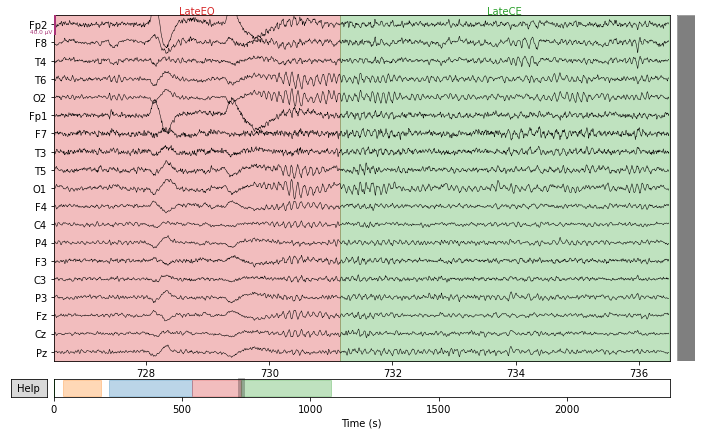

In [11]:
for idx in data:
    raw = data[idx]

    my_annot = mne.Annotations(onset=[descr['earlyOEStart'][idx], descr['earlyCEStart'][idx], descr['lateOEStart'][idx], descr['lateCEStart'][idx]],
                               duration=[descr['earlyOEStop'][idx] - descr['earlyOEStart'][idx], descr['earlyCEStop'][idx]- descr['earlyCEStart'][idx], descr['lateOEStop'][idx] - descr['lateOEStart'][idx], descr['lateCEStop'][idx] - descr['lateCEStart'][idx]],
                               description=['EarlyEO', 'EarlyEC', 'LateEO','LateCE'])

    raw.set_annotations(my_annot)


plt.rcParams['figure.figsize'] = [10, 6]



fig = data[31].plot(start=726.5, show=False)


Effective window size : 10.240 (s)
Effective window size : 10.240 (s)
Effective window size : 10.240 (s)
Effective window size : 10.240 (s)


C:\Users\alicj\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


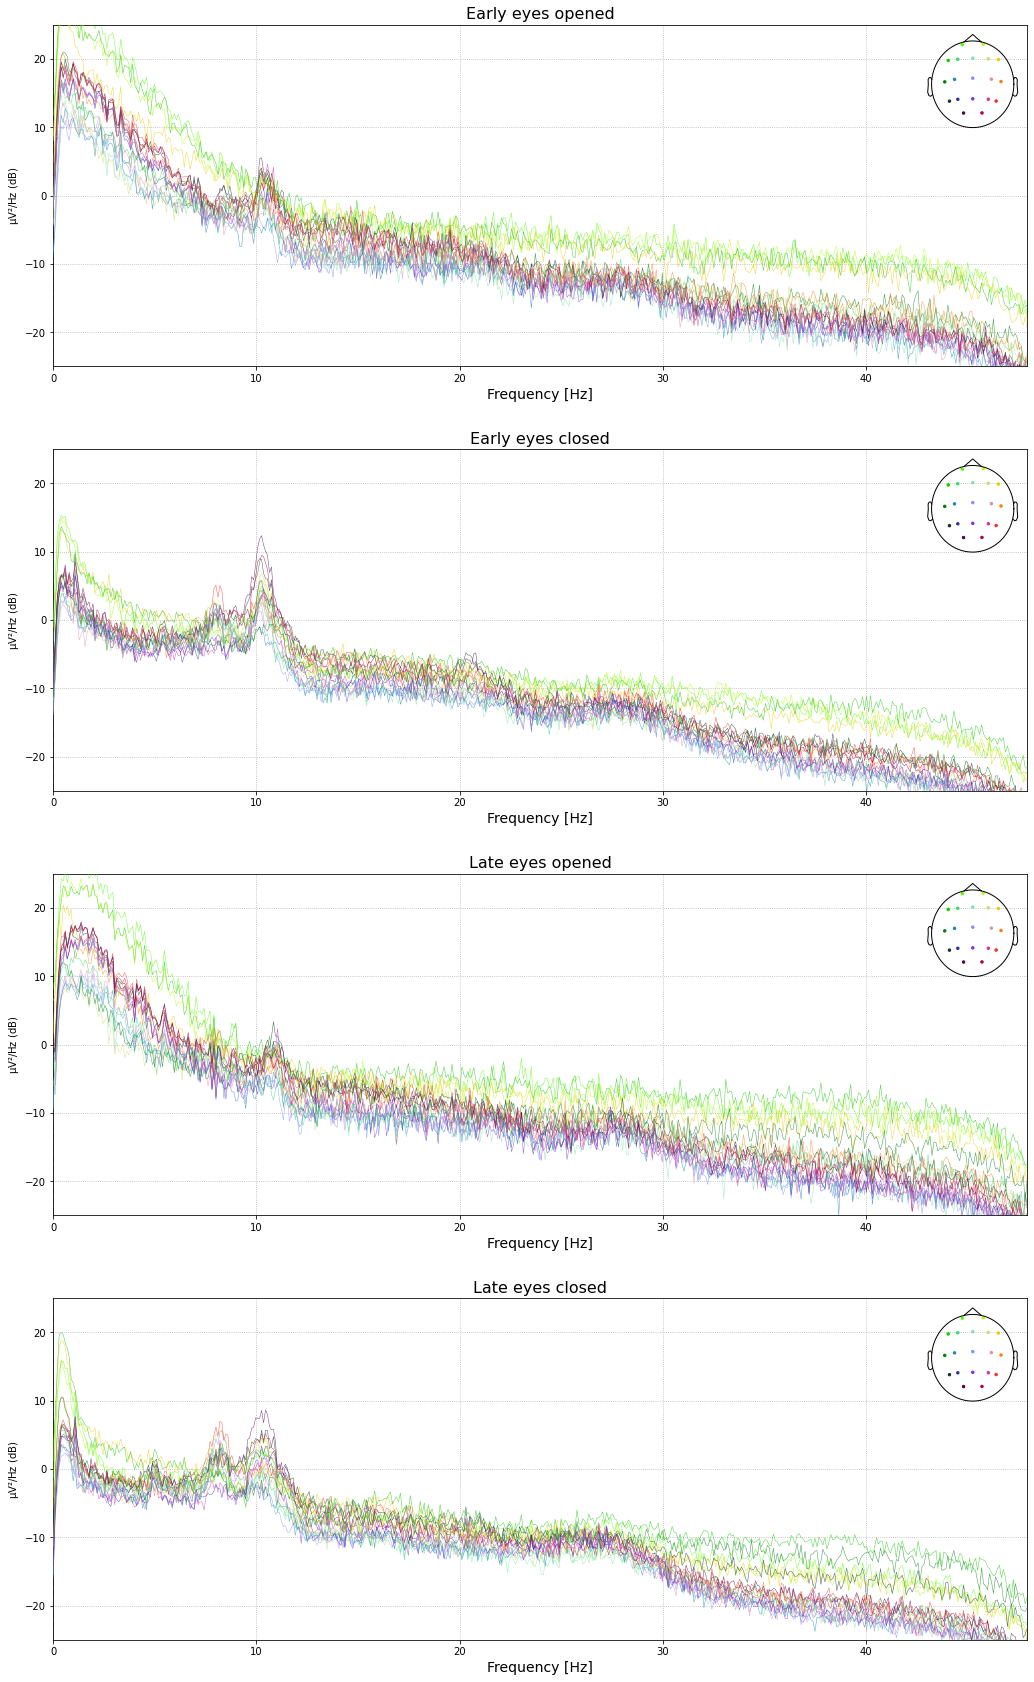

In [12]:
def psd_analysis(raw, idx):
    
    fig, axes = plt.subplots(4,1,figsize=(15,24))

    raw.plot_psd(fmax=48, tmin=descr['earlyOEStart'][idx], tmax=descr['earlyOEStop'][idx], ax=axes[0], show=False)
    raw.plot_psd(fmax=48, tmin=descr['earlyCEStart'][idx], tmax=descr['earlyCEStop'][idx], ax=axes[1], show=False)
    raw.plot_psd(fmax=48, tmin=descr['lateOEStart'][idx], tmax=descr['lateOEStop'][idx], ax=axes[2], show=False)
    raw.plot_psd(fmax=48, tmin=descr['lateCEStart'][idx], tmax=descr['lateCEStop'][idx], ax=axes[3], show=False)

    axes[0].set_title('Early eyes opened', fontsize=16)
    axes[1].set_title('Early eyes closed', fontsize=16)
    axes[2].set_title('Late eyes opened', fontsize=16)
    axes[3].set_title('Late eyes closed', fontsize=16)

    for ax in axes:
        ax.set_ylim(-25,25)
        ax.set_xlabel('Frequency [Hz]', fontsize=14)

    fig.tight_layout(pad=3.0)
    plt.show()

raw = data[7]
psd_analysis(raw, 7)

The energy in the frontopolar part of the brain was the highest, specifically from Fp1 electrode and F7. The spectral chart was cut to 48 Hz since we're more interested in lower frequencies. Above 50 Hz is considered a noise. Increased power is seen in 1Hz on whole topography. Another peak is observed around 9-10Hz. However psd plot is not giving us more relevant information since it can't tell how power is changing in time with different eye states over time.


In [13]:
def dwt_subband(signal):
    
    dwt_alpha = []
    dwt_theta = []
    dwt_delta = []
    dwt_beta = []
    
    for ch in signal:
        dwt = pywt.wavedec(ch,'db7', mode='smooth', level=7)
        
        dwt_beta.append(np.mean(dwt[4]**2) )
        dwt_alpha.append(np.mean(dwt[3]**2))
        dwt_theta.append(np.mean(dwt[2]**2))
        dwt_delta.append(np.mean(dwt[1]**2))
        
    return dwt_alpha, dwt_beta, dwt_theta, dwt_delta

def plot_topo_bands(signal, raw, title):
    
    dwt_alpha, dwt_beta, dwt_theta, dwt_delta = dwt_subband(signal)

    sfreq = raw.info['sfreq']
    
    wt_arr =[dwt_delta, dwt_theta, dwt_alpha, dwt_beta]
    fig, axes = plt.subplots(1, 4, figsize=(12,4))
    
    
    for wt, ax, subbands_title in zip(wt_arr, axes, ['Delta', 'Theta', 'Alpha', 'Beta']):
        ax.set_title(subbands_title)/
        generate_head(wt, raw, ax)

    fig.suptitle(title, fontsize=16)
    plt.show()
    

def generate_head(wt, raw, ax):
    
    mne.viz.plot_topomap(wt, raw.info, vmin=0, vmax=np.max(wt), show=False, axes=ax, names= raw.info['ch_names'], show_names=True, cmap='Spectral_r')

def get_eyestate_signal(raw, descr_instance):
    
    oestart = round(descr_instance['earlyOEStart'] * raw.info['sfreq'])
    oestop = round(descr_instance['earlyOEStop'] * raw.info['sfreq'])
    
    cestart = round(descr_instance['earlyCEStart'] * raw.info['sfreq'])
    cestop = round(descr_instance['earlyCEStop'] * raw.info['sfreq'])

    oestart_late = round(descr_instance['lateOEStart'] * raw.info['sfreq'])
    oestop_late = round(descr_instance['lateOEStop'] * raw.info['sfreq'])
    
    cestart_late = round(descr_instance['lateCEStart'] * raw.info['sfreq'])
    cestop_late = round(descr_instance['lateCEStop'] * raw.info['sfreq'])

    s, t = raw[:]
    
    return [s[:,oestart:oestop], s[:, cestart:cestop], s[:,oestart_late:oestop_late], s[:, cestart_late:cestop_late]]

def avrpower_topo_analysis(idx):
    
    raw = data[idx]
    s_eyestate = get_eyestate_signal(raw, descr.iloc[idx])
    titles= ['Early eyes opened', 'Early eyes closed','Early eyes closed','Late eyes closed']
    
    for eyestate, title in zip(s_eyestate, titles):
        
        wt = plot_topo_bands(eyestate, raw, title) 
        

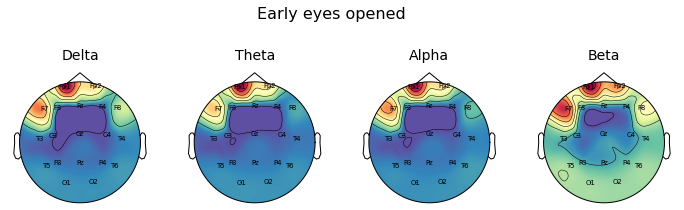

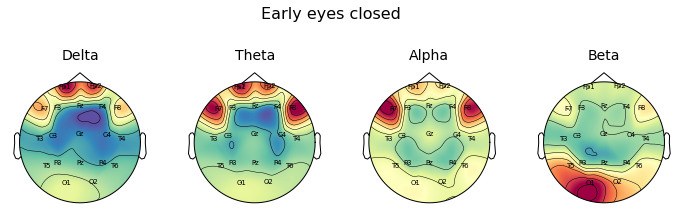

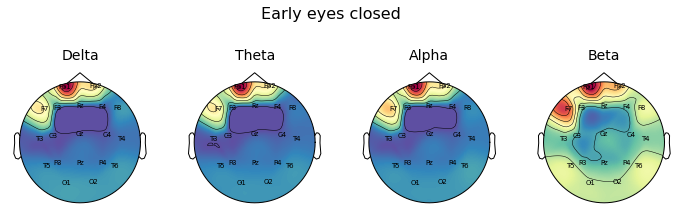

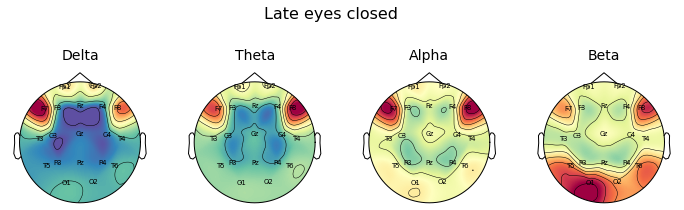

In [14]:
plt.rc('axes', labelsize=14)
plt.rc('axes', titlesize=14)
plt.rc('figure', titlesize=20)
avrpower_topo_analysis(7)

## Wavelet for feature extraction
For extracting relevant information from EEG recroding Discrete Wavelet Transform was used. The raw EEG signal was decomposed into sub-band frequencies by using the discrete wavelet transformation with the Daubechies wavelet of order 4 up to level 7. The approximate and detailed coefficients were computed (A7, D7, D6, D5, D4, D3, D2, D1). Then from the values of coeffs relative energy is calculated and this is used further as features for models. D1, D2, D3 coefficients wasn't the art of my ineterst since the frequencies from them corresponds to the noise and/or gamma brainwaves.

In [16]:
def dwt_wavelet(signal, level=7, norm=True):
    '''
    Compute discrete wavelet transform using pywt.
        
    Args:
    -----
            signal (dict): raw EEG signal from all channels
            level (int): level of DWT decomposition, default=7 bc of 200Hz sampling frequency
            norm (boolean): normalization by variation in signal, default=True

    Returns:
    --------
            data (array): arrays of coefficients for delta, theta, alpha and beta subbands
    '''
    dwt_alpha = []
    dwt_theta = []
    dwt_delta = []
    dwt_beta = []
    
    for ch in signal:
        dwt = pywt.wavedec(ch,'db4', mode='smooth', level=level)
        
        #dwt[0] is approx coeffs, and then starting at [1] the lowest decomposition lvl and ascending
        #so dwt[1] means delta subband
        
        if (norm):
            dwt_beta.append(np.mean(dwt[4]**2) / np.var(signal))
            dwt_alpha.append(np.mean(dwt[3]**2) / np.var(signal))
            dwt_theta.append(np.mean(dwt[2]**2) / np.var(signal))
            dwt_delta.append(np.mean(dwt[1]**2) / np.var(signal))
        else:
            dwt_beta.append(np.mean(dwt[4]**2))
            dwt_alpha.append(np.mean(dwt[3]**2))
            dwt_theta.append(np.mean(dwt[2]**2))
            dwt_delta.append(np.mean(dwt[1]**2))
        
    
    return [dwt_delta, dwt_theta, dwt_alpha, dwt_beta]         

In [19]:
s, t = data[7][:]
coeffs = pywt.wavedec(s,'db4', level=7)

Levels of decomposition for first electrode Fp2. Visualize the coefficients from different decomposition levels.

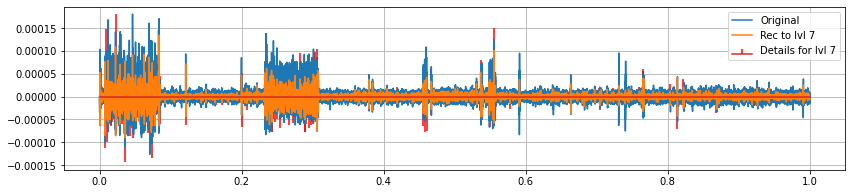

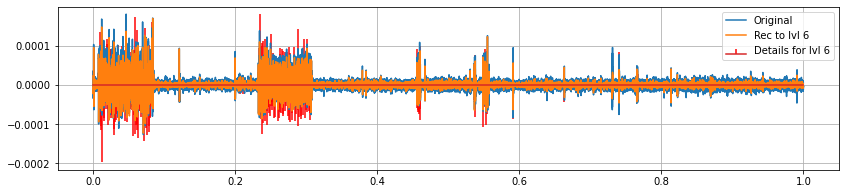

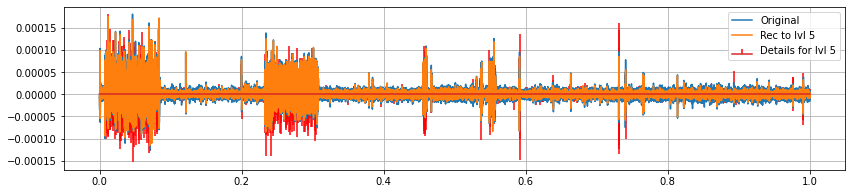

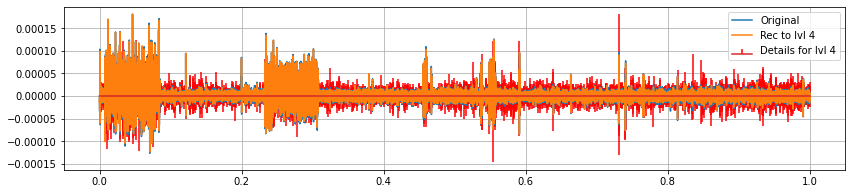

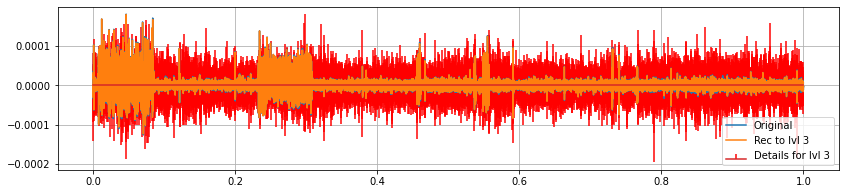

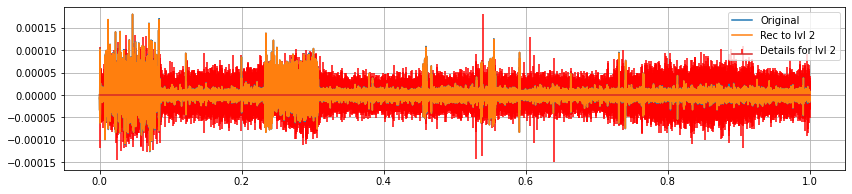

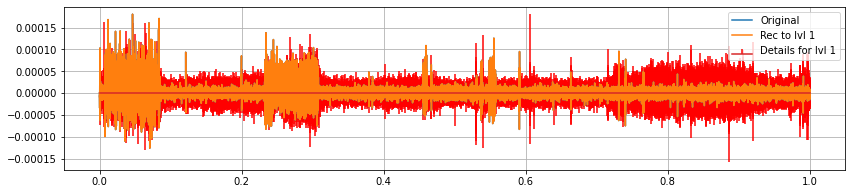

In [20]:
def reconstruction_plot(yyy, **kwargs):
   
    ym = np.median(yyy)
    plt.plot(np.linspace(0, 1., num=len(yyy)), yyy-ym, **kwargs)


def reconstruction_stem(yyy, xmax, **kwargs):
   
    ymax = yyy.max()
    plt.stem(np.linspace(0, 1., num=len(yyy)), yyy*(xmax/ymax), **kwargs)


x = s[0]
w = pywt.Wavelet('db4')
nl=7
xmax = x.max()
coeff = [i[0] for i in coeffs]
for i in range(nl):
    plt.figure(figsize=(14,3))
    plt.grid()
    reconstruction_plot(x) # original signal 
    reconstruction_plot(pywt.waverec(coeff[:i+2] + [None] * (nl-i-1), w)) # partial reconstruction 
    reconstruction_stem(coeff[i+1], xmax, markerfmt ='none', linefmt='r-')
    plt.legend(['Original', ('Rec to lvl %d')%(nl-i), ('Details for lvl %d')%(nl-i)])

## Custom split
The problem requires custom split. We want to split on patients/signals, not on samples - it prevents data leakage, which disturbs the performance of a model. https://sapienlabs.co/intra-person-variability-in-the-eeg/

In [21]:
def prepare_X(data, descr, channels, time_window=15, decompositionlvl=7):
    '''
    Calculate relative energy for time widnow segment from wavelet coefficients as features
        
    Args:
    -----
        
            data (dict): instances of mne.Raw object
            descr (pd.DataFrame): description of eeg eye-state epochs for signals in seconds 
            channels (list): names of channels to include
            time_window (int): seconds for time window segmentation of samples
            decompositionlvl (int): decomposition level of wavelet transform
    Returns:
    --------
            coeffdf_array (list): of DataFrames for every decomposition level, size is (decompositionlvl, time window, channels+2)
    
    '''
    df = prepare_dataset(data, descr, channels)
    
    ch_names = data[0].info['ch_names']
    picks = mne.pick_channels(ch_names=ch_names, include=channels)
    ch_names_corr = np.array(ch_names)[picks]
    
    fs = data[0].info['sfreq']
    v = np.arange(0, len(df), int(time_window * fs))

    coeffdf_array = [pd.DataFrame() for i in range(4)]
    
    for i in range(len(v)-1):
        temp_df = df[v[i]:v[i+1]]
        signals = np.array(temp_df.loc[:, ~temp_df.columns.isin(['Class', 'Subject'])]).T
        coeff = dwt_wavelet(signals, decompositionlvl)
    
        for j,w in enumerate(coeff):
            coeff[j].append(temp_df['Subject'].iloc[0])
            coeff[j].append(round(temp_df['Class'].mean()))
        
            coeffdf_array[j] = pd.concat([coeffdf_array[j], pd.DataFrame(coeff[j][:], index=np.ndarray.tolist(ch_names_corr)+['Subject','Class']).T]).reset_index(drop=True)
            
        
    return coeffdf_array


In [22]:
def intrapatient_split(data, descr, include_channels, train_size=0.75, time_window=15, include_mentalstate=False):
    '''
    Split data into train and test on patient/signal rather than on samples.
        
    Args:
    -----
            data (dict): instances of mne.Raw object
            descr (pd.DataFrame): description of eeg eye-state epochs for signals in seconds 
            include_channels (list): names of channels to include
            train_size (float): part of data used for training
            time_window (int): seconds for time window segmentation of samples
            include_channels (list): names of channels to include
            include_mental_state (Boolean): whether to include Subject column in classification. 
                                            It might get better results but is not universal approach.
            
    Returns:
    --------
    
            X_train (pd.DataFrame): feature matrix for train set
            y_train (list): classes for train set
            X_test (pd.DataFrame): feature matrix for test set
            y_test (list): classes for test set
            
    '''
    pts = list(data.keys()) 
 
    #previous 245, 519
    random.seed(519)
   
    pts_train = random.sample(pts, round(train_size*len(data))) 
    pts_test = [pt for pt in pts if pt not in pts_train]

    data_train = dict(enumerate(data[pt] for pt in pts_train))
    data_test = dict(enumerate(data[pt] for pt in pts_test))
    descr_train = descr.iloc[pts_train].reset_index(drop=True)
    descr_test = descr.iloc[pts_test].reset_index(drop=True)
    
    coeff_test = prepare_X(data_test, descr_test, include_channels, time_window)
    coeff_train = prepare_X(data_train, descr_train, include_channels, time_window)
    
    X_train = []
    X_test = []
    
    column_exclude = ['Class', 'Subject']
    
    if include_mentalstate:
        column_exclude = ['Class']
        
    for i,v in enumerate(coeff_test):
        
        #shuffing instances
        coeff_test[i] = coeff_test[i].sample(frac=1, random_state = 1542).reset_index(drop=True)
        coeff_train[i] = coeff_train[i].sample(frac=1, random_state = 32).reset_index(drop=True)
        
   
        X_coeff_train = coeff_train[i].loc[:, ~coeff_train[i].columns.isin(column_exclude)]
        X_coeff_test = coeff_test[i].loc[:,  ~coeff_test[i].columns.isin(column_exclude)]
        
        
        X_train.append(X_coeff_train)
        X_test.append(X_coeff_test)
        
    y_train = np.array(coeff_train[0]['Class']) # class stays the same across decomposition levels
    y_test = np.array(coeff_test[0]['Class'])
    
    
    return X_train, y_train, X_test, y_test


In [23]:
%time X_train, y_train, X_test, y_test = intrapatient_split(data, descr, include_channels = data[0].info['ch_names'], train_size = 0.8, time_window=15, include_mentalstate=True)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, Wall time: 16min 52s


# Feature selection using picked channels+PCA
Manually selected channels are based on literature and possible differences between eye states in brainwaves. Differences in alpha and beta subband are the most prominent ones. To reduce number of feature I've decided to try to only use channels from frontopolar and occitipal electrodes (front and back of the brain). Then I choose number of components for PCA by explained 95% variance in dataset. https://medium.com/analytics-vidhya/feature-extraction-techniques-pca-lda-and-t-sne-df0459c723aa

In [24]:
def pick_channels(X, include_mental_state=False):
    '''
    Manual selection of channels. Only taking alpha nad beta subband into consideration. 
    Channels are picked form frontopolar (Fp1, Fp2, Fz) and occitipal (O1, O2) electrodes.
    
        
    Args:
    -----
            X (array): array of DataFrames of computed energy for delta, theta, alpha, beta subband in this order
            include_mental_state (boolean): whether to include info about mental state of subject (depression, control, remission)
                                            default=False

    Returns:
    --------
            X_subbans (DataFrame): X DataFrame of picked channels and subbands
    '''
    alpha = X[2][['Fp2','O2', 'Fp1', 'O1', 'Fz']]
    
    
    if (include_mental_state):
        beta = X[3][['Fp2', 'O2', 'Fp1', 'O1', 'Fz', 'Subject']]
        new_columns = ['Fp2a','O2a', 'Fp1a', 'O1a', 'Fza', 'Fp2b','O2b', 'Fp1b', 'O1b', 'Fzb', 'Subject']

    else:
        beta = X[3][['Fp2', 'O2', 'Fp1', 'O1', 'Fz']]
        new_columns = ['Fp2a','O2a', 'Fp1a', 'O1a', 'Fza', 'Fp2b','O2b', 'Fp1b', 'O1b', 'Fzb']

    
    X_subbands = pd.concat([alpha, beta], axis=1)
    X_subbands.columns = new_columns
    
    return X_subbands

In [25]:
X_brainwaves_train = pick_channels(X_train)
X_brainwaves_test = pick_channels(X_test)

# scale the data - important with SVM KNN and MLP classifiers, in XGB it makes no difference (ensemble tree algorithm)
# fit on train, transform on both

scaler_brainwaves = StandardScaler(with_mean=False)
scaler_brainwaves.fit(X_brainwaves_train)
X_brainwaves_sc_train = scaler_brainwaves.transform(X_brainwaves_train)
X_brainwaves_sc_test = scaler_brainwaves.transform(X_brainwaves_test)

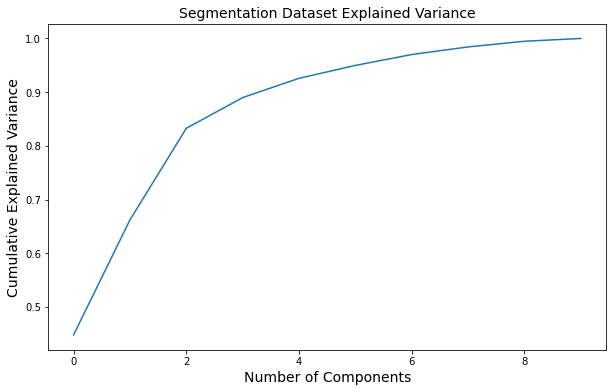

In [26]:
# choose number of components for PCA
# condition: it must explain around 95% variance of dataset
plot_pca(X_brainwaves_sc_train)

In [27]:
pca = PCA(n_components=6)

# fit on train, transform on both
fit = pca.fit(X_brainwaves_sc_train)

X_train_pca = pca.transform(X_brainwaves_sc_train)
X_test_pca = pca.transform(X_brainwaves_sc_test)

## SVC 
Support Vector Machine Classifier calculations requires prior scaling to data, bc the values of coeffs are big, and it caulculates the surface of hyperplane. RBF kernel was used because it performed the best. 

SVC
Cross-validation
Accuracy:  [0.91489362 0.91134752 0.90780142 0.90070922 0.89679715 0.90391459
 0.92170819 0.90035587 0.91103203 0.92882562]
Mean accuracy:  0.910 (+/- 0.010)

Test
accuracy: 0.878
f1 score macro av: 0.844
recall score macro av: 0.829
precision score macro av: 0.866
f1 score for every class:  [0.91694352 0.7716895 ]
recall:  [0.94520548 0.71308017]
precision:  [0.89032258 0.84079602]
 
Confusion matrix


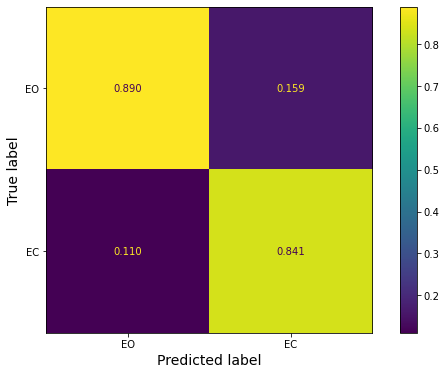

In [28]:
svc_pca = SVC(kernel='rbf') 
evaluate_model(svc_pca, X_train_pca, y_train, X_test_pca, y_test) 

## MLP
Multilayer Perceptron also requires prior scaling. It consist of outer and hidden layers. I chose 3 hidden layers and it was enough to get good accuracy. Maximum itertaion was set to 5000. Intriduced random state to recieve comparable results each time.

MLPClassifier
Cross-validation
Accuracy:  [0.91134752 0.90070922 0.91134752 0.90425532 0.89679715 0.90747331
 0.91814947 0.89679715 0.90035587 0.9252669 ]
Mean accuracy:  0.907 (+/- 0.009)

Test
accuracy: 0.882
f1 score macro av: 0.850
recall score macro av: 0.838
precision score macro av: 0.867
f1 score for every class:  [0.91896408 0.78202247]
recall:  [0.94178082 0.73417722]
precision:  [0.89722675 0.83653846]
 
Confusion matrix


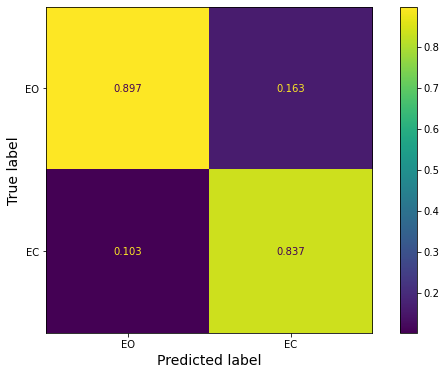

In [29]:
mlp_pca = MLPClassifier(solver='lbfgs', max_iter=5000, hidden_layer_sizes=(3, ), random_state=1234)
evaluate_model(mlp_pca, X_train_pca, y_train, X_test_pca, y_test)

## XGBoost
Extreme Gradient Boosting is a boosting algorithm, it combines a set of weak learners and delivers improved prediction accuracy. Its default base learners is tree ensemble. It's really popular and high-performance algorithm. The key thing is to choose right hyper-parameters. Below I use GridSearch from scikit so the model could choose the best ones.

In [30]:

parameters = {
     "eta"    : [0.05, 0.10, 0.20],
     "max_depth"        : [ 5, 6, 8],
     "colsample_bytree" : [ 0.5 , 0.7, 0.8],
     "n_estimators"     : [ 50, 100, 150, 200]
     }

bst = xgb.XGBClassifier()
grid = GridSearchCV(bst, parameters, n_jobs=-1, scoring="neg_log_loss", cv=3)

%time grid.fit(X_train_pca, y_train)

Wall time: 19.5 s


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [31]:
print("Best estimator found by grid search:")
print(grid.best_estimator_)

Best estimator found by grid search:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eta=0.05, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.0500000007, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


XGBClassifier
Cross-validation
Accuracy:  [0.90425532 0.91843972 0.91134752 0.90070922 0.90035587 0.89679715
 0.92170819 0.90747331 0.90391459 0.91459075]
Mean accuracy:  0.908 (+/- 0.008)

Test
accuracy: 0.877
f1 score macro av: 0.843
recall score macro av: 0.827
precision score macro av: 0.864
f1 score for every class:  [0.91618257 0.76887872]
recall:  [0.94520548 0.70886076]
precision:  [0.88888889 0.84      ]
 
Confusion matrix


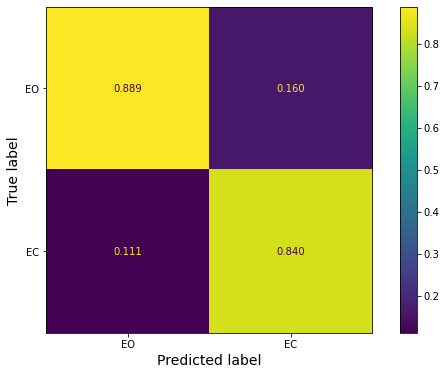

In [32]:
params = {'eta' : 0.05, 'max_depth': 6, 'n_estimators': 100, 'colsample_bytree' : 0.7}
bst_pca = xgb.XGBClassifier(**params)
evaluate_model(bst_pca, X_train_pca, y_train, X_test_pca, y_test) 

## KNN
k-Nearest Neighbours - simple classifier. Each sample represents point in n-dimensional pattern space. When the algorithm receives a new sample, it looks for the said sample space which is closest to the reported sample. Chose 15 neighbours as parameter.

KNeighborsClassifier
Cross-validation
Accuracy:  [0.90070922 0.91843972 0.92198582 0.90070922 0.90747331 0.90747331
 0.9252669  0.91103203 0.90391459 0.92882562]
Mean accuracy:  0.913 (+/- 0.010)

Test
accuracy: 0.882
f1 score macro av: 0.850
recall score macro av: 0.838
precision score macro av: 0.867
f1 score for every class:  [0.91896408 0.78202247]
recall:  [0.94178082 0.73417722]
precision:  [0.89722675 0.83653846]
 
Confusion matrix


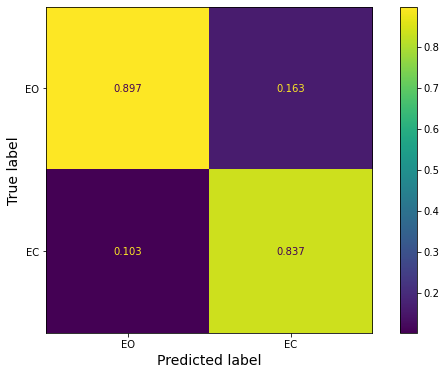

In [33]:
knn_pca = KNeighborsClassifier(n_neighbors=15)
evaluate_model(knn_pca, X_train_pca, y_train, X_test_pca, y_test)

## Box plot comparison

In [34]:
def compare_models(models, X_train, y_train):
    results, names = list(), list()
    for name, model in models.items():
        scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1, error_score='raise')
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

    fig, ax = plt.subplots(figsize=(10,8))
    ax.boxplot(results, labels=names, showmeans=True)
    ax.set_ylabel('Accuracy [-]', fontsize=16)
    ax.set_ylim(0.85,0.95)
    plt.xticks(fontsize= 18) 
    plt.show()

>SVC 0.910 (0.010)
>MLP 0.907 (0.008)
>XGB 0.908 (0.008)
>KNN 0.913 (0.010)


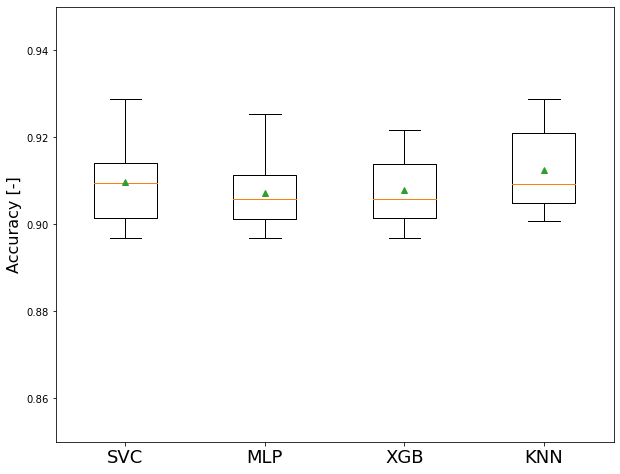

In [35]:
models = models = dict()
models['SVC'] = svc_pca
models['MLP'] =  mlp_pca
models['XGB'] = bst_pca
models['KNN'] = knn_pca

compare_models(models, X_train_pca, y_train)

# Feature extraction using FDR+PCA
Second approach: its performed on all channels from all coeffs. I let algorithms choose best ones by FDR. Details of this approach are in the link below
https://www.frontiersin.org/articles/10.3389/fncom.2017.00103/full

In [36]:
df_train = pd.concat([X_train[0].drop('Subject', axis=1), X_train[1].drop('Subject', axis=1), X_train[2].drop('Subject', axis=1), X_train[3].drop('Subject', axis=1)], axis=1) 

In [37]:
df_test = pd.concat([X_test[0].drop('Subject', axis=1), X_test[1].drop('Subject', axis=1), X_test[2].drop('Subject', axis=1), X_test[3].drop('Subject', axis=1)], axis=1)

In [38]:
scaler_fdrpca = StandardScaler(with_mean=False)
scaled_train = scaler_fdrpca.fit_transform(df_train)
scaled_test = scaler_fdrpca.transform(df_test)

df_train = pd.DataFrame(scaled_train)
df_test = pd.DataFrame(scaled_test)

In [39]:
def FDR(X_train, y_train):
    '''
    Calculates Fischer discriminant ratio. 
        
    Args:
    -----
        
            X_train (DataFrame): feature DataFrame
            y_train (array): class array
            
    Returns:
    --------
            features_idx (array): output of FDR for features
                            
    '''
    
    idx_CE = np.where(y_train == 0)[0]
    idx_OE = np.where(y_train == 1)[0]
    
    mean_ce = X_train.iloc[idx_CE].mean()
    var_ce = X_train.iloc[idx_CE].var()
    
    mean_oe = X_train.iloc[idx_OE].mean()
    var_oe = X_train.iloc[idx_OE].var()
    
   
    fdr = [(mean_ce[i] - mean_oe[i])/(var_ce[i] - var_oe[i]) for i, v in enumerate(mean_ce)]
    
    extracted_fdr = sorted(fdr, reverse=True)[:len(fdr)//2] # return above median
    features_idx = np.where([fdr == v for v in extracted_fdr])[1]
    
    return features_idx

In [40]:
features_idx = FDR(df_train, y_train)

In [41]:
X_fdr = df_train[features_idx]
X_fdr_test = df_test[features_idx]

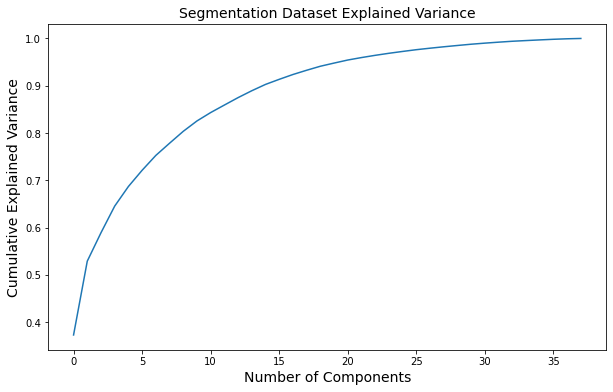

In [43]:
plot_pca(X_fdr)

In [45]:
pca_fdr = PCA(n_components=20)
fit = pca_fdr.fit(X_fdr)

X_train_fdrpca = pca_fdr.transform(X_fdr)
X_test_fdrpca = pca_fdr.transform(X_fdr_test)

## SVC

SVC
Cross-validation
Accuracy:  [0.91843972 0.92907801 0.91489362 0.90070922 0.91459075 0.91103203
 0.93238434 0.90747331 0.9252669  0.9430605 ]
Mean accuracy:  0.920 (+/- 0.012)

Test
accuracy: 0.872
f1 score macro av: 0.834
recall score macro av: 0.815
precision score macro av: 0.863
f1 score for every class:  [0.91358025 0.75409836]
recall:  [0.95034247 0.67932489]
precision:  [0.87955626 0.84736842]
 
Confusion matrix


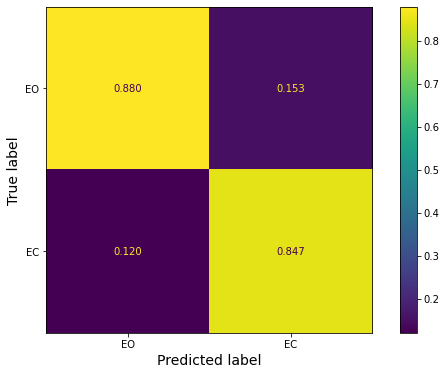

In [47]:
svc_fdrpca = SVC(kernel='rbf')
evaluate_model(svc_fdrpca, X_train_fdrpca, y_train, X_test_fdrpca, y_test)

## MLP

MLPClassifier
Cross-validation
Accuracy:  [0.90780142 0.92198582 0.91134752 0.90780142 0.90391459 0.86476868
 0.92170819 0.91103203 0.90747331 0.92170819]
Mean accuracy:  0.908 (+/- 0.016)

Test
accuracy: 0.883
f1 score macro av: 0.853
recall score macro av: 0.843
precision score macro av: 0.866
f1 score for every class:  [0.91946309 0.78666667]
recall:  [0.93835616 0.74683544]
precision:  [0.90131579 0.83098592]
 
Confusion matrix


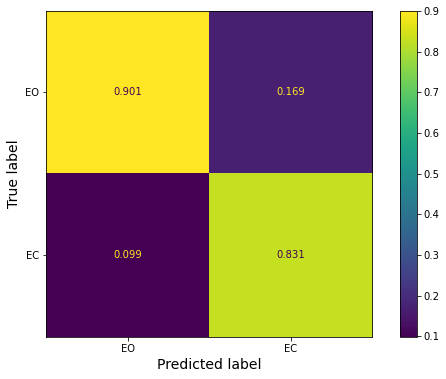

In [48]:
mlp_fdrpca = MLPClassifier(solver='lbfgs', max_iter=5000, hidden_layer_sizes=(3, ), random_state=1234)
evaluate_model(mlp_fdrpca, X_train_fdrpca, y_train, X_test_fdrpca, y_test)

## XGBoost

In [49]:

parameters = {
     "eta"    : [0.05, 0.10, 0.20],
     "max_depth"        : [ 5, 6, 8],
     "colsample_bytree" : [ 0.5 , 0.7, 0.8],
     "n_estimators"     : [ 50, 100, 150, 200]
     }

bst = xgb.XGBClassifier()
grid = GridSearchCV(bst, parameters, n_jobs=-1, scoring="neg_log_loss", cv=3)

%time grid.fit(X_train_fdrpca, y_train)

Wall time: 48.2 s


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [50]:
print("Best estimator found by grid search:")
print(grid.best_estimator_)

Best estimator found by grid search:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


XGBClassifier
Cross-validation
Accuracy:  [0.90780142 0.92553191 0.91134752 0.90070922 0.90391459 0.91814947
 0.93238434 0.91814947 0.91103203 0.93594306]
Mean accuracy:  0.916 (+/- 0.011)

Test
accuracy: 0.866
f1 score macro av: 0.826
recall score macro av: 0.807
precision score macro av: 0.855
f1 score for every class:  [0.90953947 0.74178404]
recall:  [0.94691781 0.66666667]
precision:  [0.875      0.83597884]
 
Confusion matrix


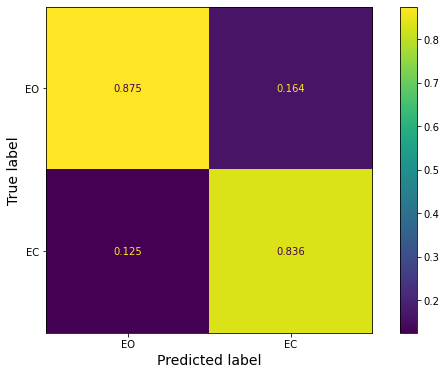

In [51]:
paramsfdr = {'eta' : 0.1, 'max_depth': 6, 'n_estimators': 50, 'colsample_bytree' : 0.7}
bst_fdrpca = xgb.XGBClassifier(**paramsfdr)
evaluate_model(bst_fdrpca, X_train_fdrpca, y_train, X_test_fdrpca, y_test)

## KNN

KNeighborsClassifier
Cross-validation
Accuracy:  [0.91134752 0.92198582 0.90425532 0.90070922 0.90747331 0.89323843
 0.92882562 0.90391459 0.92170819 0.93238434]
Mean accuracy:  0.913 (+/- 0.012)

Test
accuracy: 0.870
f1 score macro av: 0.831
recall score macro av: 0.813
precision score macro av: 0.859
f1 score for every class:  [0.91178895 0.75058275]
recall:  [0.94691781 0.67932489]
precision:  [0.87917329 0.83854167]
 
Confusion matrix


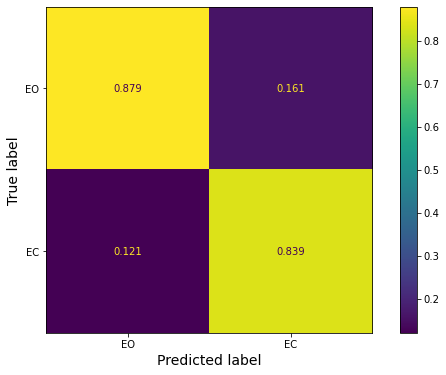

In [52]:
knn_fdrpca = KNeighborsClassifier(n_neighbors=15)
evaluate_model(knn_fdrpca, X_train_fdrpca, y_train, X_test_fdrpca, y_test)

## Box plot comparison

>SVC 0.920 (0.012)
>MLP 0.908 (0.016)
>XGB 0.916 (0.011)
>KNN 0.913 (0.012)


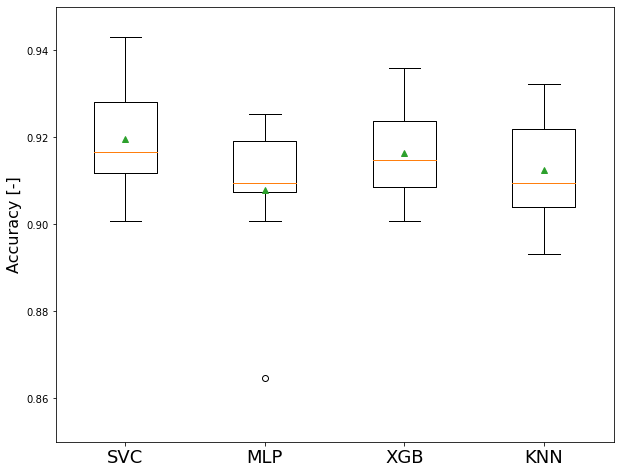

In [53]:
models_fdr = dict()
models_fdr['SVC'] = svc_fdrpca
models_fdr['MLP'] = mlp_fdrpca
models_fdr['XGB'] = bst_fdrpca
models_fdr['KNN'] = knn_fdrpca

compare_models(models_fdr, X_train_fdrpca, y_train)


# Validation
Training process was performed on features from 15seconds time intervals. Here I visualize the output of trained classifiers on whole signal by intruding sliding window of time 15s with 80% overlap (3s).

In [54]:
def val_prepare(file, channels): 
    
    ch_names = file.info['ch_names']
    picks = mne.pick_channels(ch_names=ch_names, include=channels)
        
    signal, time = file[picks]
        
    df_signal = pd.DataFrame(signal.T, columns=np.array(ch_names)[picks]) 
   
        
    df_signal = df_signal.dropna().reset_index(drop=True)
    
    return df_signal

def prepare_Xval(raw, channels, time_window=15, moving_time=3, decopositionlvl=7):
    
    
    df = val_prepare(raw, channels)
    ch_names = raw.info['ch_names']
    picks = mne.pick_channels(ch_names=ch_names, include=channels)
    ch_names_corr = np.array(ch_names)[picks]
    
    fs = raw.info['sfreq']
    
    coeffdf_array = [pd.DataFrame() for i in range(4)]

    print('Wavelet energies are being calculated for given sliding time window. This may take a while.')
    
    b=0
    e=int(time_window * fs)
    
    while e <= len(df):
        temp_df = df[b:e]
        signals = np.array(temp_df.loc[:]).T
        
        coeff = dwt_wavelet(signals, decopositionlvl)
        b = b + moving_time*int(fs)
        e = e + moving_time*int(fs)
        
        for j,w in enumerate(coeff):
        
            coeffdf_array[j] = pd.concat([coeffdf_array[j], pd.DataFrame(coeff[j][:], index=np.ndarray.tolist(ch_names_corr)).T]).reset_index(drop=True)
        
    return coeffdf_array


In [55]:
from cycler import cycler
  
def plot_eye_state(raw, y, time_window=20, moving_time=1):
    
    fig, ax = plt.subplots(figsize=(17,10))
   
    hexc = ['indigo', 'purple', 'mediumvioletred','yellowgreen','darksalmon', 'sandybrown','firebrick','lightseagreen','skyblue','mediumseagreen','palegreen']
    ax.set_prop_cycle((cycler(color=hexc)))
    
    fs = raw.info['sfreq']
    s,t = raw[:]
    
    for channel in s:
        ax.plot(t, channel, linewidth=1)

    tpred = np.arange(time_window, len(t)/fs, moving_time).astype(int)
   
    plt.axvspan(0, 0, color='gold', alpha=0.2, label='Eyes opened')
    plt.axvspan(0, 0, color='mediumblue', alpha=0.2, label='Eyes closed')
    
    for j, v in enumerate(y):
        if j ==0:
            if v == 1:
                plt.axvspan(0, time_window, color='gold', alpha=0.2)
            else:
                plt.axvspan(0, time_window, color='mediumblue', alpha=0.2)
        else:
            if v == 1:
                plt.axvspan(tpred[j-1], tpred[j-1]+moving_time, color='gold', alpha=0.2)
            else:
                plt.axvspan(tpred[j-1], tpred[j-1]+moving_time, color='mediumblue', alpha=0.2)

    ax.legend()
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Amplitude [V]')
    plt.grid()
    plt.show() 


In [56]:
def acc_signal(raw, y_pred, descr, time_window, moving_time):
    
    toe = [[descr['earlyOEStart'], descr['earlyOEStop']], [descr['lateOEStart'],descr['lateOEStop']]]
    tce = [[descr['earlyCEStart'], descr['earlyCEStop']], [descr['lateCEStart'], descr['lateCEStop']]]
    
    s,t = raw[:]
    fs = raw.info['sfreq']
    tpred = np.array([0])
    tpred = np.append(tpred, np.arange(time_window, len(s[0])/fs, moving_time))
    
    preds = np.array([])

    for i in range(len(y_pred)-1):
        if y_pred[i] == 1:
            preds = np.append(preds, np.ones(int(tpred[i+1] - tpred[i])))
        else:
            preds = np.append(preds, np.zeros(int(tpred[i+1] - tpred[i])))

    
    eoe, loe = acc_eyestate(preds, toe, 1)
    ece, lce = acc_eyestate(preds, tce, 0) 
    
    return eoe, loe, ece, lce

In [57]:
def acc_eyestate(pred, tes, class_binary):

    eye_state = []
    for i in range(len(tes)):
        eye_state.append(sum(pred[round(tes[i][0]):round(tes[i][1])] == class_binary)/len(pred[round(tes[i][0]):round(tes[i][1])]))
    
    return eye_state[0], eye_state[1]

In [58]:
def compare_classified(raw, y_pred, descr, time_window, moving_time, save=False, title=None):
    
    s,t = raw[:] #signal and time
    fs = raw.info['sfreq']
    
    toe = [[descr['earlyOEStart'], descr['earlyOEStop']],[descr['lateOEStart'],descr['lateOEStop']]]
    tce = [[descr['earlyCEStart'], descr['earlyCEStop']],[descr['lateCEStart'], descr['lateCEStop']]]
    
    ts = np.array([0])
    ts = np.append(ts, np.arange(time_window, len(s[0])/fs, moving_time))
    
    if (len(ts) != len(y_pred)):
        ts = ts[:-1]
        
    eoe, loe, ece, lce = acc_signal(raw, y_pred, descr, time_window, moving_time)
    
    print('Early OE accuracy: %.3f' %eoe)
    print('Late OE accuracy: %.3f' %loe)
    print('Early CE accuracy: %.3f' %ece)
    print('Late CE accuracy: %.3f' %lce)
    
    plt.figure(figsize=(17,10))
    plt.axvspan(0, 0,  ymin=0.95, ymax=1, color='gold', alpha=0.2, label='Marked EO')
    plt.axvspan(0, 0,  ymin=0.95, ymax=1, color='mediumblue', alpha=0.2, label='Marked EC')
    #ymin=0.95, ymax=1,
    for i,v in enumerate(toe):
        plt.axvspan(toe[i][0], toe[i][1], color='gold', alpha=0.2)
        plt.axvspan(tce[i][0], tce[i][1], color='mediumblue', alpha=0.2)
        
    plt.plot(ts,y_pred, c='mediumblue', label='Predicted eye state \n 1 - EO \n 0 - EC')
    plt.xlabel('Time [s]', fontsize=14)
    plt.ylabel('Class', fontsize=14)
    plt.yticks(fontsize= 18) 
    plt.yticks([0,1])
    plt.title('Comparison of classification to true state', fontdict = {'fontsize' : 20})
    plt.grid()
    plt.legend(prop={'size': 14})
    
    if (save):
        plt.savefig(title)
    plt.show()
    
    return ts, y_pred
   

## Original dataset

In [59]:
idx = 63
X_dan = prepare_Xval(data[idx], channels=['Fp2','F8','T4','T6','O2','Fp1','F7','T3','T5','O1','F4','C4','P4','F3','C3','P3', 'Fz', 'Cz','Pz'], time_window=15, moving_time=3)

Wavelet energies are being calculated for given sliding time window. This may take a while.


In [60]:
X_brainwaves_dan = pick_channels(X_dan)
X_brainwaves_dan = scaler_brainwaves.transform(X_brainwaves_dan)
#PCA CHECK
X_dan_pca = pca.transform(X_brainwaves_dan) 

dan_pred = svc_pca.predict(X_dan_pca)
dan_predmlp = mlp_pca.predict(X_dan_pca)
dan_predxgb = bst_pca.predict(X_dan_pca)
dan_predknn = knn_pca.predict(X_dan_pca)

Early OE accuracy: 0.967
Late OE accuracy: 0.851
Early CE accuracy: 0.969
Late CE accuracy: 0.997


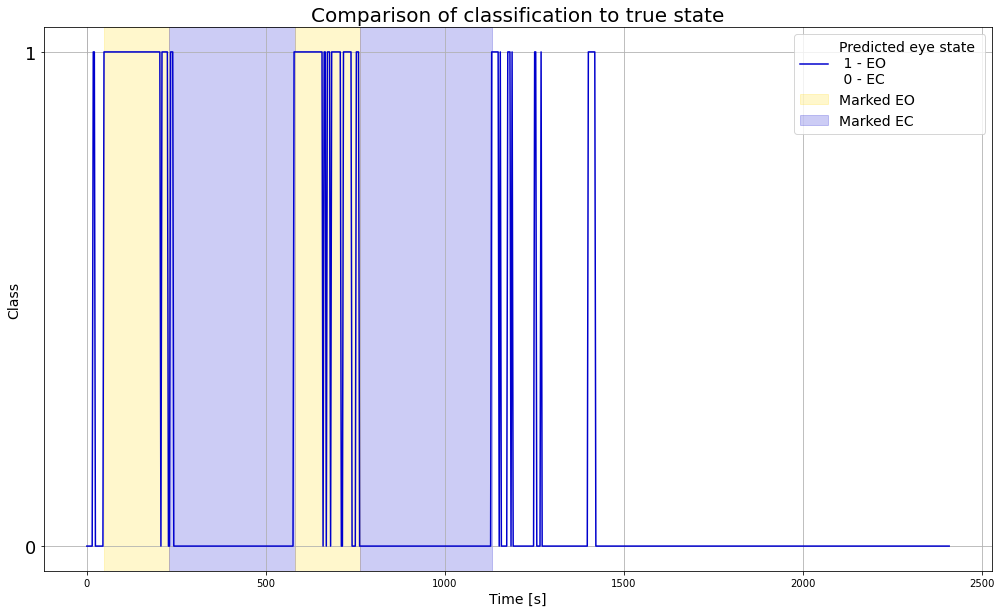

In [61]:
idx = 63
ts, ypred = compare_classified(data[idx], dan_predknn, descr.iloc[idx], 15, 3, save=True, title="comparison.png")

C:\Users\alicj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


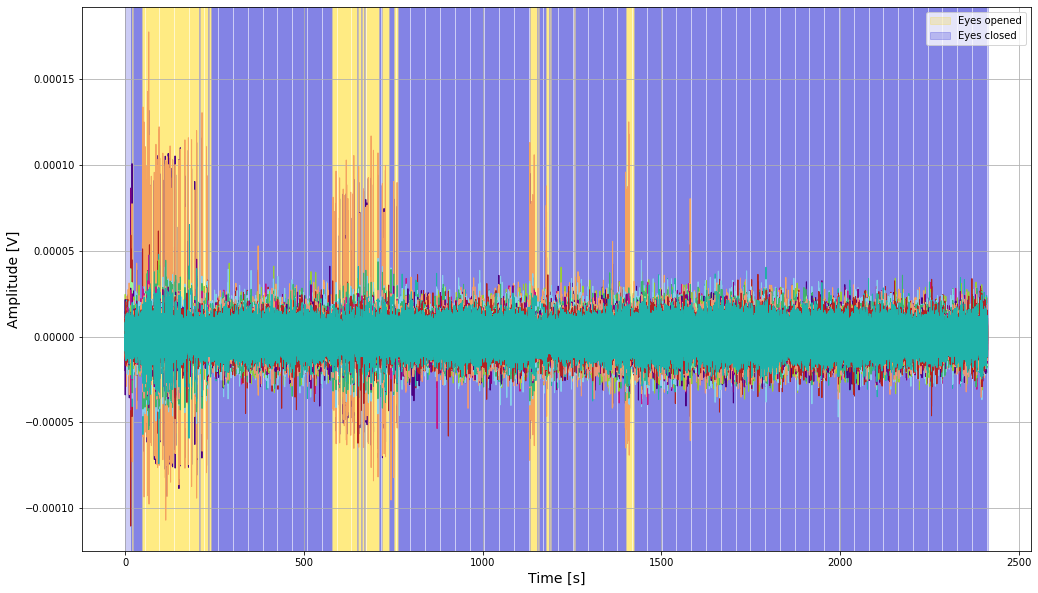

In [62]:
plot_eye_state(data[idx], dan_pred, time_window=15, moving_time=3)

# Summary and comment


In the last two charts the rest of the signal which is not in description made by technician (not resting state) model classified it as eyes closed, which is in fact accurate - I found out that this time interval is representing hyperventialtion state which is performed with eyes closed.


Manual selection proved its relevance - I reduced number of features for PCA to choose from. Models were based only on 6 features and it was enough to achieve high accuracy. FDR method used 20 features and was worse in terms of accuracy - some of them may not be crucial in classification problem or may not be universal for all subjects.


Worse classificator was XGBoost. The best performances come from k-NN and MLP in manual selection (88,2%). Models in general better classified closed eyes to opened eyes (results from more data in this class - might consider balancing it in the future).